In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import numpy as np
import os
import json
import joblib
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Load feature vector

In [2]:
feature_path = "/Users/trananhvu/Documents/CV/data/feature"
# HOG + Openface
hog_openface_feature_path = os.path.join(feature_path, "hog_openface")
# MTCNN + Facenet
mtcnn_facenet_feature_path = os.path.join(feature_path, "mtcnn_facenet")

In [3]:
def get_feature(feature_path, feature_extraction_type):
    list_feature = []
    list_label = []
    if feature_extraction_type=="openface":
        size = 128
    elif feature_extraction_type=="facenet":
        size = 512
    for i in os.listdir(feature_path):
        if i==".DS_Store":
            continue
        for j in os.listdir(os.path.join(feature_path, i)):
            if j==".DS_Store":
                continue
            list_label.append(i)
            feature=np.load(os.path.join(os.path.join(feature_path, i), j))
            list_feature.append(feature.reshape(size).tolist())
    return list_label, list_feature

In [4]:
list_label_hog, list_hog_openface_feature = get_feature(hog_openface_feature_path, feature_extraction_type="openface")
list_label_mtcnn, list_mtcnn_facenet_feature = get_feature(mtcnn_facenet_feature_path, feature_extraction_type="facenet")

# Prepare for training

In [6]:
# Face label to index
count=0
label_2_idx = {}
hog_idx_list = []
mtcnn_idx_list = []
for i in list_label_hog:
    if i not in label_2_idx:
        label_2_idx[i]=count
        count+=1
    hog_idx_list.append(label_2_idx[i])
for i in list_label_mtcnn:
    mtcnn_idx_list.append(label_2_idx[i])

In [7]:
label_2_idx

{'Robert Downey Jr': 0,
 'Chris Evans': 1,
 'Mark Ruffalo': 2,
 'Chris Hemsworth': 3,
 'Scarlett Johansson': 4,
 'Unknown': 5,
 'Tom Holland': 6}

In [8]:
model_path = "/Users/trananhvu/Documents/CV/CV_internship/face_recognition/step_by_step_face_recognition/model"
svm_model_hog_openface_path = os.path.join(model_path, "hog_openface_svm_model.sav")
svm_model_mtcnn_facenet_path = os.path.join(model_path, "mtcnn_facenet_svm_model.sav")
knn_model_hog_openface_path = os.path.join(model_path, "hog_openface_knn_model.sav")
knn_model_mtcnn_facenet_path = os.path.join(model_path, "mtcnn_facenet_knn_model.sav")

In [9]:
with open(os.path.join(model_path, "face2idx.json"), "w") as outfile:
    json.dump(label_2_idx, outfile)

# Face recognition

## SVM

### HOG + Openface 

In [15]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(list_hog_openface_feature, hog_idx_list, test_size=0.33,
                                                    random_state=4, stratify=hog_idx_list)
# Training SVM model
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(x_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
# Save model
joblib.dump(clf, svm_model_hog_openface_path)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10000.0, class_weight='balanced', gamma=0.0001)


['/Users/trananhvu/Documents/CV/CV_internship/face_recognition/step_by_step_face_recognition/model/hog_openface_svm_model.sav']

In [95]:
print("HOG + Openface + SVM accuracy: ")
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

HOG + Openface + SVM accuracy: 


0.892271662763466

In [13]:
idx_2_face = {y: x for x, y in label_2_idx.items()}
def plot_confusion_matrix(array):
    df_cm = pd.DataFrame(array, index = [idx_2_face[i] for i in range(7)], 
                        columns = [idx_2_face[i] for i in range(7)])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()

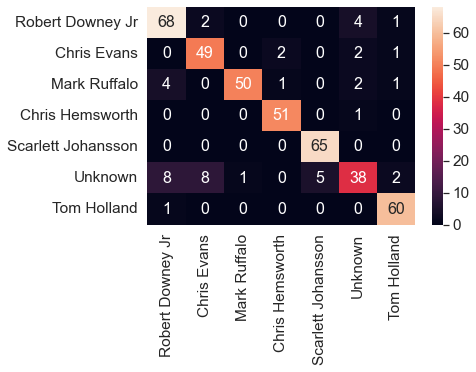

In [97]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

### MTCNN + Facenet 

In [70]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(list_mtcnn_facenet_feature, mtcnn_idx_list, test_size=0.33,
                                                    random_state=4, stratify=mtcnn_idx_list)
# Training SVM model
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(x_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
# Save model
joblib.dump(clf, svm_model_mtcnn_facenet_path)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1)


['/Users/trananhvu/Documents/CV/CV_internship/face_recognition/step_by_step_face_recognition/model/mtcnn_facenet_svm_model.sav']

In [71]:
print("MTCNN + Facenet + SVM accuracy: ")
y_pred_svm = clf.predict(x_test)
accuracy_score(y_test, y_pred_svm)

MTCNN + Facenet + SVM accuracy: 


0.9902439024390244

## KNN

### HOG + Openface 

In [10]:
x_train, x_test, y_train, y_test = train_test_split(list_hog_openface_feature, hog_idx_list, test_size=0.33,
                                                    random_state=4, stratify=hog_idx_list)
# Training KNN model
param_grid = {
        'n_neighbors': [3, 5, 7]
        }
clf = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid)
clf.fit(x_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
# Save model
joblib.dump(clf, knn_model_hog_openface_path)

Best estimator found by grid search:
KNeighborsClassifier(n_neighbors=3, weights='distance')


['/Users/trananhvu/Documents/CV/CV_internship/face_recognition/step_by_step_face_recognition/model/hog_openface_knn_model.sav']

In [11]:
print("HOG + Openface + KNN accuracy: ")
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

HOG + Openface + KNN accuracy: 


0.9016393442622951

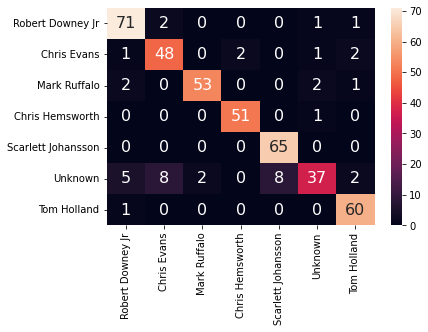

In [14]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

### MTCNN + Facenet

In [74]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(list_mtcnn_facenet_feature, mtcnn_idx_list, test_size=0.33,
                                                    random_state=4, stratify=mtcnn_idx_list)
# Training KNN model
param_grid = {
        'n_neighbors': [3, 5, 7]
        }
clf = GridSearchCV(KNeighborsClassifier(), param_grid)
clf.fit(x_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
# Save model
joblib.dump(clf, knn_model_mtcnn_facenet_path)

Best estimator found by grid search:
KNeighborsClassifier(n_neighbors=3)


['/Users/trananhvu/Documents/CV/CV_internship/face_recognition/step_by_step_face_recognition/model/mtcnn_facenet_knn_model.sav']

In [75]:
print("MTCNN + Facenet + KNN accuracy: ")
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

MTCNN + Facenet + KNN accuracy: 


0.9780487804878049

## KNN + Distance threshold

Ta chỉ xét hog+openface

In [33]:
def get_feature(feature_path):
    list_feature = []
    list_label = []
    label_unknown = 0
    list_feature_unknown = []
    size = 128
    for i in os.listdir(feature_path):
        if i==".DS_Store":
            continue
        for j in os.listdir(os.path.join(feature_path, i)):
            if j==".DS_Store":
                continue
            feature=np.load(os.path.join(os.path.join(feature_path, i), j))
            if i=="Unknown":
                list_feature_unknown.append(feature.reshape(size).tolist())
            if i!="Unknown":    
                list_label.append(i)
                list_feature.append(feature.reshape(size).tolist())
    return list_label, list_feature, list_feature_unknown

In [34]:
list_label, list_feature, list_feature_unknown = get_feature(hog_openface_feature_path)

In [35]:
# Face label to index
count=0
label_2_idx = {}
label_idx_list = []
for i in list_label:
    if i not in label_2_idx:
        label_2_idx[i]=count
        count+=1
    label_idx_list.append(label_2_idx[i])

In [62]:
label_2_idx["Unknown"]=len(label_2_idx)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(list_feature, label_idx_list, test_size=0.33,
                                                    random_state=4, stratify=label_idx_list)

In [41]:
y_test+=[label_2_idx["Unknown"]]*len(list_feature_unknown)
x_test+=list_feature_unknown

In [47]:
# Training KNN model
param_grid = {
        'n_neighbors': [3, 5, 7]
        }
clf = KNeighborsClassifier(n_neighbors = 3, weights='distance')
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [64]:
def predict(clf, x_test, threshold):
    predict=[]
    for feat in x_test:
        closest_distances = clf.kneighbors([feat], n_neighbors=1)
        if closest_distances[0][0][0]<=threshold:
            predict.append(clf.predict([feat])[0])
        else:
            predict.append(label_2_idx["Unknown"])
    return predict

list_threshold = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
result = {}
for i in list_threshold:
    print("Threshold: "+str(i))
    result[i] = predict(clf, x_test, i)

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


In [65]:
idx_2_label={y: x for x, y in label_2_idx.items()}

In [66]:
def plot_confusion_matrix(result, threshold):
    pred = result[threshold]
    print("Accuracy score with threshold = "+str(threshold)+": "+str(accuracy_score(y_test, pred)))
    array = confusion_matrix(y_test, pred)
    df_cm = pd.DataFrame(array, index = [idx_2_label[i] for i in range(7)], 
                        columns = [idx_2_label[i] for i in range(7)])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.title("Confusion matrix with threshold = "+str(threshold))
    plt.show()

Accuracy score with threshold = 0.7: 0.8188405797101449


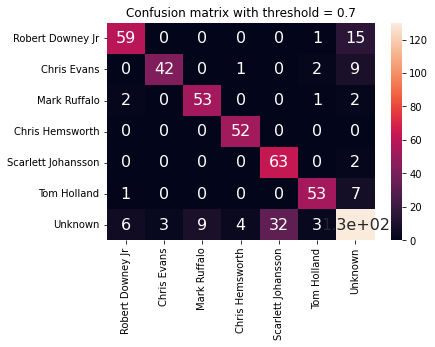

In [73]:
plot_confusion_matrix(result, threshold=0.7)